# (공부) 논문 작성
> proposed method

- toc:true
- branch: master
- badges: true
- comments: true
- author: 김하영
- categories: [Study]

---

## Abstract

AI는 빠른 속도로 발전하고 있으며, 이미지 판별 등에서 활발하게 사용되고 있다. 우리가 잘 알고 있는 예제 CAT/DOG, MNIST와 같이 매우 높은 정확도로 분류해내는 경우도 있지만 여전히 한계점은 존재한다..
>늑대, 개를 눈(snow)로 구분한 예시 https://towardsdatascience.com/explainability-and-visibility-in-covid-19-x-ray-classifiers-with-deep-learning-c12c3247f905


이런 한계점을 보완하기 위해 본 논문에서는 CNN으로 데이터를 학습한 후 CAM을 활용해 반복적으로 클래스를 분류한 특징을 탐색해보려 한다. 반복적으로 특징을 탐색하는 이유는 첫 번째 판별해낸 특징이 실제 사람이 이미지를 판별할 때 사용하는 특징(=일반적인 특징)이 아닐 수 있기 때문이다. 또한 첫번째 시도 이후 발견한 특징들은 사람이나, 딥러닝 알고리즘에서 중요하지 않게 생각하거나 미처 고려하지 못한 부분으로 우리에게 다른 시사점을 제공할 수 있다.  



## Method

### ✏️ **Simulation Study**  

#### 1. Datasets

**The Oxford-IIIT Pet Dataset**  
ref : https://www.robots.ox.ac.uk/~vgg/data/pets/  

```python
dls=ImageDataLoaders.from_name_func(path,files,label_func,item_tfms=Resize(512))
```

사용할 데이터는 37종의 개, 고양이 이미지로 총 7349개이다. DataLoaders를 이용하여 데이터를 불러왔으며 이미지 사이즈는 $512*512$ 로 통일시켰다. 따라서 이후 분석에 사용될 이미지 shape은 $1*3*512*512$이다.

#### 2. CNN
``` python
lrnr=cnn_learner(dls,resnet34,metrics=error_rate)
lrnr.fine_tune(1)
```
pretrained model인 resnet34를 사용하여 cnn_learner를 생성하였다. CNN 후 CAM을 진행할 수 있도록 resnet34를 일부 수정했다. 수정한 net2와 net1을 통합해 새로운 `net`이라는 이름의 network를 생성하여 학습을 진행했다.

첫번째 CAM이 발견한 특징을 제거한 후 CAM을 재실행하여 첫번째 시도에서 놓친(비교적 약하다고 판별된) 특징을 확인하는 과정을 반복적으로 수행할 것이기 때문에 특징의 면적이 좁을수록 이후 판별되는 특징과 구별이 수월하다. 따라서 epoch 수를 일반적인 학습의 경우보다 많게 진행하여 과적합을 유도하였다.(최소 5회 이상)
>❓이 때 epoch수가 많다고 하여 면적이 좁게 나타나는 것은 아니었다. 고양이로 실험한 경우를 보면, epoch=5일 때 강아지 epcoh=25일 때와 유사한 CAM img 움직임을 보였다. 고양이 epoch=25일 때는 어떤 이유인지 설명하기는 어려우나, 1번째 CAM img만 유의하게 나타나고 2번째 CAM img에서는 1번째 시도에서 분리해낸 부분 외 모든 부분이 고양이로 분류되는데 기여한 부분으로 확인되었다. 이것도 어떻게 보면 과적합되었기 때문이려나? 

한 개 이미지를 선택하여 텐서화를 진행했다. 텐서화된 이미지는 `x`라 하며, 이전 0-255 사이의 값을 가지던 픽셀들이 -3-3 사이의 값을 가지게 되었다. 이에 따라 이미지의 대비가 높아져 향후 이미지 시각화 시 원본 이미지에 가까운 색을 띌 수 있게 선형변환을 진행할 예정이다.

> CNN과 CAM 과정 요약  
Input image shape : $3X512X512$ $\to$ CNN $\to$ CAM image shpae : $3X16X16$  
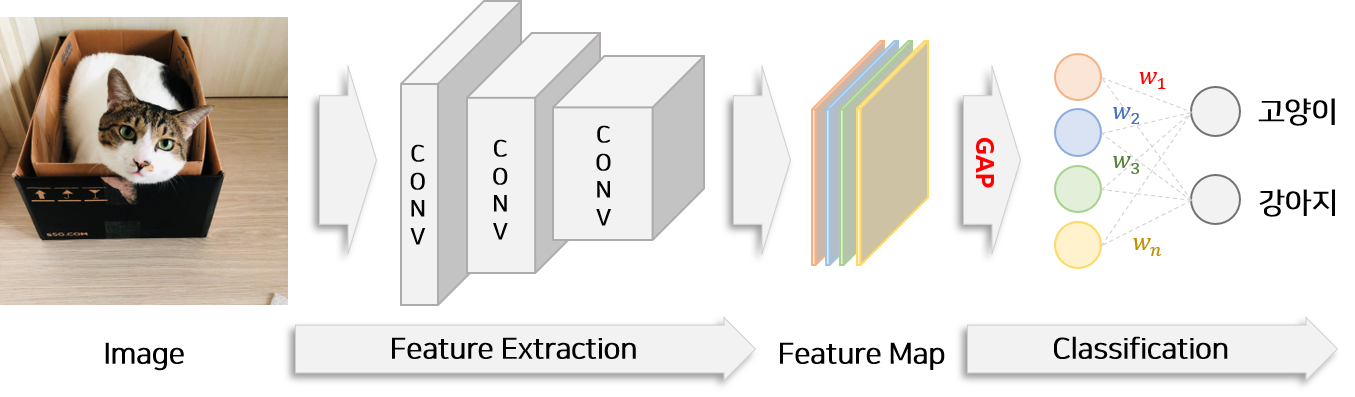  
$\to$ 이런 이미지를 만들어서 넣고 싶음

Class = Cat, Dog 이기 때문에 CAMimg[0]은 `Cat part`, CAMimg[1]은 `Dog part`가 된다. 각 이미지는 Cat/Dog으로 클래스가 분류되는데 기여한 부분을 시각화하며, 픽셀값이 클수록(기여도가 높을수록, 양수이고 절대값이 클수록) 보라색에 가까운 색상을, 픽셀값이 작을수록(기여도가 적을수록, 음수이고 절대값이 클수록) 파란색에 가까운 색상을 띈다. 따라서 해당 데이터에서는 평균이 양수이면 고양이로 판별하고, 평균이 음수이면 개로 판별한다.
> 이를 식으로 나타내면 아래와 같다.  
> - 특징변수 $F_k$를 출력함.  
> $\sum_{x,y} f_k(x,y)=F_x$    
> - 클래스 c에 대한 softmax함수 입력값 $S_c$은 특징변수와 Weight를 곱하여 계산함.  
> $S_c = \sum_k w^c_k F_k$  
> - softmax 함수에 입력값을 넣어 계산한 결과 $P_c$=각 클래스로 분류될 확률이 도출됨.  
> $P_c = \frac{exp(S_c)}{\sum_c exp(S_c)}$  
>> $k$ : Feture Map의 index  
>> $x,y$ : Feature Map의 가로(x), 세로(y) 좌표  
>> $f_k(x,y)$ : k번째 Feature Map의 visual pattern  
>> $F_k$ : k번째 Feature Map의 특징변수  
>> $w^c_k$ : 클래스 c에 k번째 Feature Map의 특징변수가 얼마나 중요한지를 보여주는 값  
> - 클래스 c에 대한 Class Activation Map $M_c$는 k번째 Feature Map의 각 가로, 세로 값에 weight를 곱한 값을 더한 것과 같음.  
$M_c(x,y) = \sum_k w^c_k f_k(x,y) \to S_c = \sum_{x,y} M_c(x,y)$  


> ref : Zhou, Bolei, et al. "Learning deep features for discriminative localization." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

이미지가 고양이일 경우 CAM img[0], 이미지가 개일 경우 CAM img[1]를 사용하여 약간의 선형변환을 해줄 것이다. $T$는 CAM img 각 픽셀에서 CAM img의 최솟값을 빼준 것으로, 기여도가 적으면 0, 기여도가 클수록 값이 커진다.
> $T$ = CAMimg[0]-torch.min(CAMimg[0]
>❓이름을 뭐라고 설정해주는 것이 좋을까? new cam weight..?

$T$를 사용해 CAM에서 발견한 특징의 가중치를 낮추는 `mode weigth`와 CAM에서 발견한 특징을 제외한 부분의 가중치를 높이는 `mode res weight`를 생성하고, 원본 이미지와 weight를 곱해 mode img와 mode res img를 생성한다. mode res img는 각 픽셀에서 최솟값을 빼주는데, 이는 이미지 시각화할 때, 원본 이미지를 텐서화하면서 높아진 대비도를 조정해주기 위함이다.   
또한 시각화와 weight 범위 조절을 위해 $k$라는 hyper parameter값을 곱해주는데,
- $k$의 값이 클수록, CAM img의 가중치에 큰 값이 곱해져 이미지가 어떤 클래스로 분류되는데 기여한 부분의 범위가 넓어지며(=mode weight에서 분홍색으로 표시되는 부위가 실제 CAM img보다 넓어짐), residual에서는 더욱 어둡게 나타난다.
- $k$의 값이 작을수록, CAM img의 가중치에 큰 값이 곱해져 이미지가 어떤 클래스로 분류되는데 기여한 부분의 범위가 CAM img에서 나타난 것과 유사하나, residual에서 완벽하게 지워지지가 않아서 다음 차수에서 동일한 부분이 탐색될 가능성이 높다.  
따라서 $k$값은 여러 값을 시뮬레이션한 후 가장 시각화가 자연스러운 값으로 임의 선택하였다.

> 위의 내용을 식으로 정리하면 아래와 같다.  
$mode weigth : me=exp(-k*T)$  
$mode res weight : mr=1-exp(-k*T)$
$mode img : me*x$
$mode res img :mr*x-torch.min(mr*x)$
>> x=original image


만약 sample image가 Dog이라면, 

과적합을 위해 25회 학습을 진행하였으나, 고양이 이미지에서 처음에 얼굴을 판별해 낸 이후 얼굴을 제외한 모든 부분이 고양이로 판별된 이유로 (동일한 가중치를 가지고)확인되어서 epoch수를 늘려 보았다. (총 epoch=40) 40으로 늘렸더니 너무 이동이 느리다..

CAM img를 가중치로 보다 쉽게 사용할 수 있도록(?. 맞나?) 0~1 범위로 만들어주기 위해 각 픽셀 값에서 최소 픽셀값을 빼주었다.

In [58]:
a=net(x).tolist()[0][0]
b=net(x).tolist()[0][1]
np.exp(a)/(np.exp(a)+np.exp(b)), np.exp(b)/(np.exp(a)+np.exp(b))

(0.9999999998182874, 1.8171263787640942e-10)

In [505]:
np.exp(a)

41041.7438618806

In [509]:
np.exp(b)

7.457803541545435e-06

In [507]:
net(x.to("cpu")).tolist()[0][0]

10.622979164123535

In [508]:
net(x.to("cpu")).tolist()[0][1]

-11.806629180908203

✏️ **Real Data Study**
- k=0.04로 진행해본 결과, 이전 언급한 것과 같이 1차에서 발견된 특징이 잘 지워지지 않았다. 따라서 2번째 CAM에서 발견된 특징이 1번째 CAM에서 발견된 특징과 유사하다.
- k=0.055로 진행해본 결과, 1차에서 발견된 특징이 residual img에서 잘 지워졌으나(검정색에 가깝게 나타났으나, 픽셀의 값이 0에 가깝게 나타났으나) 폐 내부?의 시각적인 특징들도 함께 사라져 2번째 CAM에서 엉뚱한 결과를 초래했다.

